## Imports

In [1]:
from fastai2.vision.all import *
import torch.utils.data as data

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.models.detection as detection
from matplotlib.patches import Rectangle
from PIL import ImageDraw 
import cv2

from engine import train_one_epoch, evaluate
import utils
import transforms as T

## Get images from video

In [2]:
mkdir input_frames

In [3]:
file = '2_1.mp4'
video = cv2.VideoCapture(file)
fps = video.get(cv2.CAP_PROP_FPS)

In [4]:
fps

29.97002997002997

## Create Labels for the data


Getting 1 frame per second.

In [5]:
img_files = 0
while True:
    for i in range(29):
        (grabbed, frame) = video.read()
        if grabbed: img = frame
        if not grabbed or i ==28:
            cv2.imwrite(f'input_frames/{img_files}.jpg',img)
            img_files += 1
            break
    if not grabbed:break
            
    

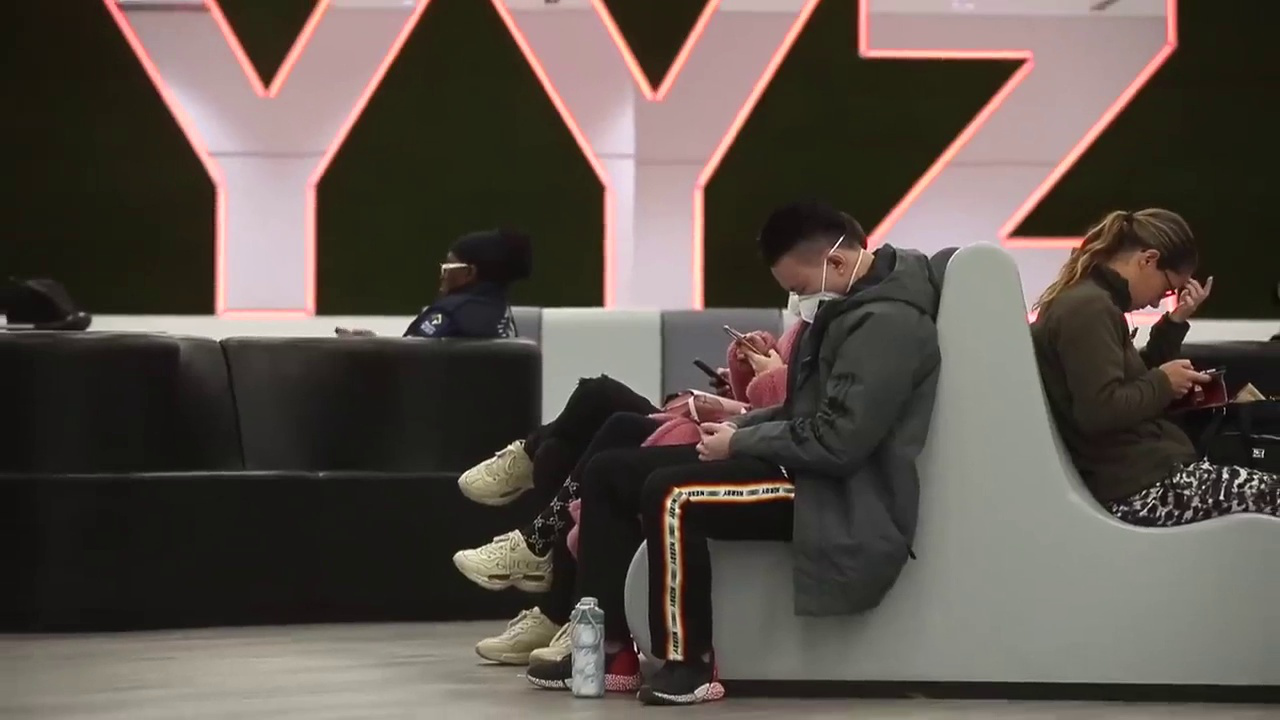

In [6]:
ann_imgs_path = Path('input_frames/')
fnames_ann_img = sorted(list(ann_imgs_path.iterdir()))
Image.open(fnames_ann_img[0])

## Annotate the above images with a pretrained faster rcnn model

Faster rcnn model is trained on a popular dataset called Ccoco and it contains close to 80 objects.

In [11]:
annotations = []

In [12]:
fnames_ann_img[:2]

[Path('input_frames/0.jpg'), Path('input_frames/1.jpg')]

In [20]:
idx = 0

In [35]:
def print_ls(path_obj):
    for o in path_obj.ls():print(o)

def get_processed_image(path):
    im  = Image.open(path).convert('RGB')
    im,_ = T.ToTensor()(im,'')
    return im

def boxes_above_th(prediction,th=0.5):
    prediction = pred_to_numpy(prediction)
    boxes = []
    for i,o in enumerate(prediction['scores']):
        if o > th:
            boxes.append(prediction['boxes'][i])
    return boxes

def labels_boxes_above_th(prediction,th=0.5):
    boxes = boxes_above_th(prediction, th=th)
    prediction = pred_to_numpy(prediction)
    labels = []
    for i,o in enumerate(prediction['scores']):
        if o > th:
            labels.append(prediction['labels'][i])
    
    return labels,boxes

def get_preds(model,img):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    return prediction[0]

def pred_to_numpy(preds):return {o:preds[o].cpu().numpy() for o in preds.keys()} 

def draw_bb(img,boxes):
    img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    fig, ax = plt.subplots(figsize=(10,5))
    ax.imshow(img)
    for o in boxes:
        x1,y1,x2,y2 = o
        rect = Rectangle((x1,y1),(x2-x1),(y2-y1),linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
def get_img_bbox(img,boxes,labels=None):
    color = 'yellow'
    img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    img1 = ImageDraw.Draw(img)
    for i,o in enumerate(boxes):
        x1,y1,x2,y2 = o
        if labels[i] == 1: 
            img1.rectangle([(x1,y1),(x2,y2)],fill =None,outline = color )
            img1.text((x1,y1-20),'No Mask', fill='white')
    return img

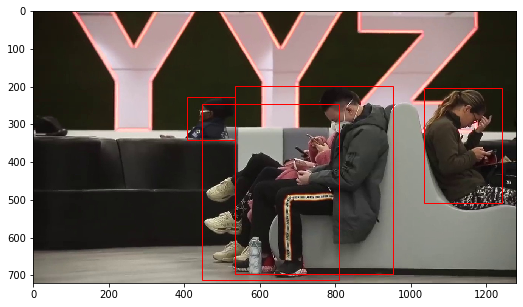

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
f_path = fnames_ann_img[idx]
img = get_processed_image(f_path)
model = detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
preds = get_preds(model,img)
person_idxs = [i for i,label in enumerate(preds['labels'].cpu().numpy()) if label ==1]
for k,v in preds.items():
    preds[k] = preds[k][person_idxs]
th = 0.5
labels,boxes = labels_boxes_above_th(preds,th)
draw_bb(img,boxes_above_th(preds, th))

In [23]:
#f_path.unlink()
f_path

Path('input_frames/0.jpg')

In [24]:
labels,[o*2 for o in labels ]

([1, 1, 1, 1], [2, 2, 2, 2])

In [25]:
 boxes

[array([1034.6576 ,  202.89897, 1240.4244 ,  508.7828 ], dtype=float32),
 array([533.6323 , 199.15697, 952.78986, 697.1217 ], dtype=float32),
 array([408.166  , 228.45926, 534.7406 , 340.46106], dtype=float32),
 array([447.8336 , 246.44519, 809.5842 , 712.2747 ], dtype=float32)]

In [719]:
labels = [2, 2, 2, 2]

In [720]:
assert len(boxes) == len(labels)

In [721]:
annotations.append(([{'name':f_path.name, 'boxes':boxes,'labels':labels}]))

In [ ]:
# pickle.dump(annotations,open('2_1_mask_annotation.pkl',mode='wb'))

## Create Dataset on our newly annotated data

We will include PennFudanPed dataset which has got annotated data for pedestrians. We will club the aannotation along with our own annotated data.

In [7]:
path = Path('../data/PennFudanPed/PennFudanPed/')
fnames = sorted(list((path/'PNGImages').iterdir()))
fmasks = sorted(list((path/'PedMasks').iterdir())) 

In [8]:
ann = pickle.load(open('2_1_mask_annotation.pkl',mode='rb'))

Convert filenames to paths and boxes, labels to numpy arrays

In [9]:
ann = [o[0] for o in ann]
for o in ann:o['name'] = Path('2_1frames')/o['name'] 
for o in ann:o['boxes'] = np.array(o['boxes'])
for o in ann:o['labels'] = np.array(o['labels'])

In [10]:
ann[0]

{'name': Path('2_1frames/0.jpg'),
 'boxes': array([[ 670.3933 ,  224.73125,  942.0774 ,  670.1939 ],
        [1029.5627 ,  209.96701, 1236.3712 ,  549.8731 ],
        [ 491.55505,  195.87375,  908.218  ,  673.4238 ]], dtype=float32),
 'labels': array([2, 1, 2])}

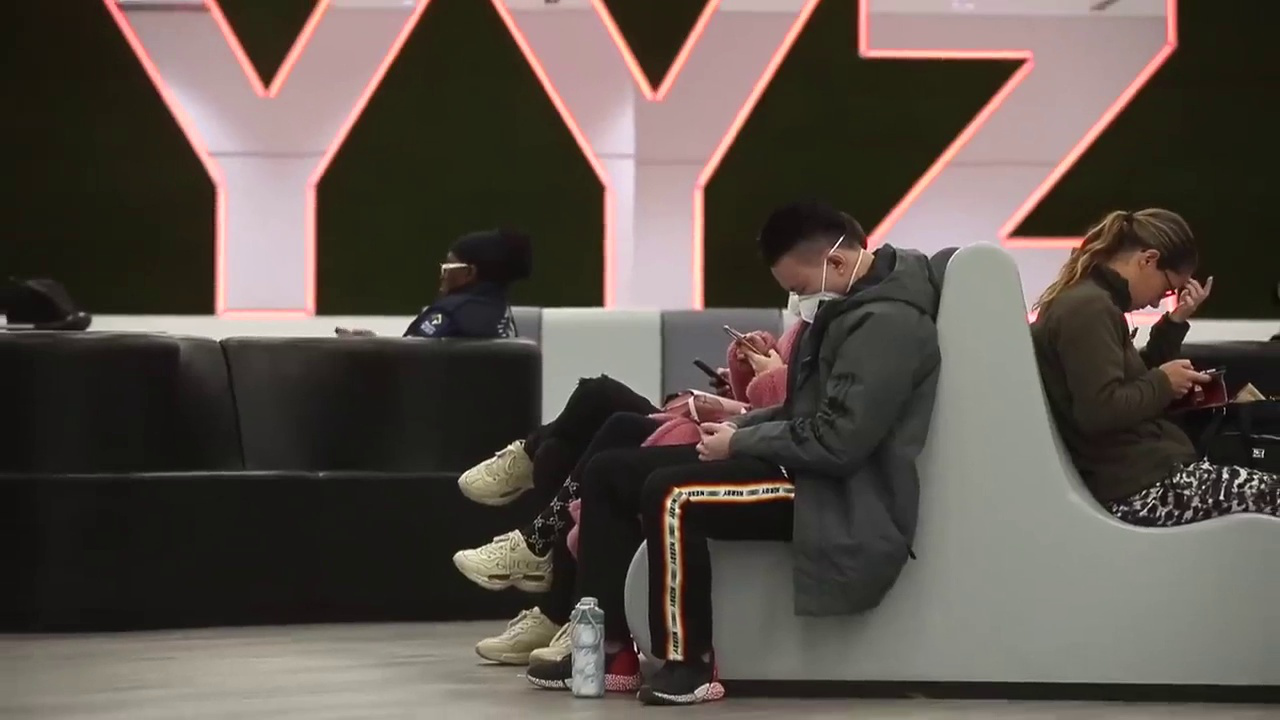

In [43]:
Image.open(ann[0]['name'])

In [11]:
len(fmasks),len(ann)

(170, 104)

Converting PennFudanPed dataset into a format similar to hand annotated data

In [12]:
person_dataset = []
for i,masks_path in enumerate(fmasks):
    msk = Image.open(masks_path)
    msk = np.array(msk)
    obj_ids = np.unique(msk)[1:]
    masks = msk == obj_ids[:,None,None]
    boxes = []
    num_objs = len(obj_ids)
    for num in range(num_objs):
        pos = np.where(masks[num])
        x_min = np.min(pos[1])
        x_max = np.max(pos[1])
        y_min = np.min(pos[0])
        y_max = np.max(pos[0])
        boxes.append([x_min,y_min,x_max,y_max])
    assert num_objs == len(boxes)
    boxes = np.array(boxes)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = np.zeros((num_objs,), dtype=np.int64)
    labels = np.ones((num_objs,), dtype=np.int64)
    person_dataset.append({'name':fnames[i],'boxes':boxes,'labels':labels,'area':area,'iscrowd':iscrowd})

In [13]:
person_dataset[:2]

[{'name': Path('../data/PennFudanPed/PennFudanPed/PNGImages/FudanPed00001.png'),
  'boxes': array([[159, 181, 301, 430],
         [419, 170, 534, 485]]),
  'labels': array([1, 1]),
  'area': array([35358, 36225]),
  'iscrowd': array([0, 0])},
 {'name': Path('../data/PennFudanPed/PennFudanPed/PNGImages/FudanPed00002.png'),
  'boxes': array([[ 67,  92, 190, 379]]),
  'labels': array([1]),
  'area': array([35301]),
  'iscrowd': array([0])}]

Faster Rcnn model expects few parameters like area and crowd because it was used with the original cooc dataset. We will calculate the area and add dummy values for crowd, since we are not going to use it.

In [14]:
for o in ann:
    bb = np.array(o['boxes'])
    area = (bb[:, 3] - bb[:, 1]) * (bb[:, 2] - bb[:, 0])
    iscrowd = np.zeros((len(bb),), dtype=np.int64)
    o['area'] = area
    o['iscrowd'] = iscrowd

Combine the 2 datasets

In [15]:
comb_ann = []
for o in person_dataset:comb_ann.append(o)
for o in ann:comb_ann.append(o)
assert len(comb_ann) == len(person_dataset) + len(ann)

In [16]:
class MaskNoMaskDataset(torch.utils.data.Dataset):
    def __init__(self,ds,transforms=None):
        self.ds = deepcopy(ds)
        self.transforms = transforms
        
    def __getitem__(self,idx):
        o = deepcopy(self.ds[idx])
        img = Image.open(o['name']).convert('RGB')
        image_id = torch.tensor([idx])
        boxes = torch.from_numpy(o['boxes']).type(torch.float32)
        area = torch.from_numpy(o['area']).type(torch.float32)
        labels = torch.from_numpy(o['labels'])
        iscrowd = torch.from_numpy(o['iscrowd'])
        target = {'boxes':boxes,'labels':labels,'image_id':image_id,'area':area,'iscrowd':iscrowd}       
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img,target
    
    def __len__(self):
        return len(self.ds)


In [17]:
ds = MaskNoMaskDataset(comb_ann)

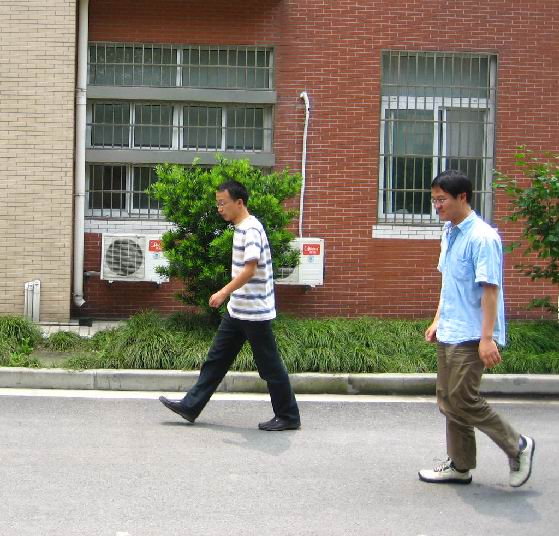

In [18]:
ds[0][0]

In [19]:
ds[0][1]

{'boxes': tensor([[159., 181., 301., 430.],
         [419., 170., 534., 485.]]),
 'labels': tensor([1, 1]),
 'image_id': tensor([0]),
 'area': tensor([35358., 36225.]),
 'iscrowd': tensor([0, 0])}

## Creating DataLoader

In [20]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [24]:
dataset = MaskNoMaskDataset(comb_ann, get_transform(train=True))
dataset_test = MaskNoMaskDataset(comb_ann, get_transform(train=False))

In [25]:
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-2])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-2:])

In [26]:
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

In [27]:
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

## Modify Faster RCNN model to identify people with no mask

In [28]:
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

In [46]:
FastRCNNPredictor(in_features,num_classes)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=3, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
)

## Train the model

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device);
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
num_epochs = 30

In [ ]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/136]  eta: 0:23:42  lr: 0.000042  loss: 1.4192 (1.4192)  loss_classifier: 1.2851 (1.2851)  loss_box_reg: 0.1261 (0.1261)  loss_objectness: 0.0050 (0.0050)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 10.4560  data: 0.1774  max mem: 9843
Epoch: [0]  [ 10/136]  eta: 0:05:37  lr: 0.000412  loss: 1.4192 (1.2737)  loss_classifier: 1.1706 (1.0247)  loss_box_reg: 0.2026 (0.2144)  loss_objectness: 0.0199 (0.0196)  loss_rpn_box_reg: 0.0114 (0.0150)  time: 2.6768  data: 0.0240  max mem: 10751
Epoch: [0]  [ 20/136]  eta: 0:04:27  lr: 0.000782  loss: 0.7177 (0.9322)  loss_classifier: 0.4083 (0.6812)  loss_box_reg: 0.2064 (0.2181)  loss_objectness: 0.0199 (0.0188)  loss_rpn_box_reg: 0.0115 (0.0141)  time: 1.8973  data: 0.0074  max mem: 10826


## Test the model

In [38]:
model.load_state_dict(torch.load('models/person_without_mask_new_data.pth'))

<All keys matched successfully>

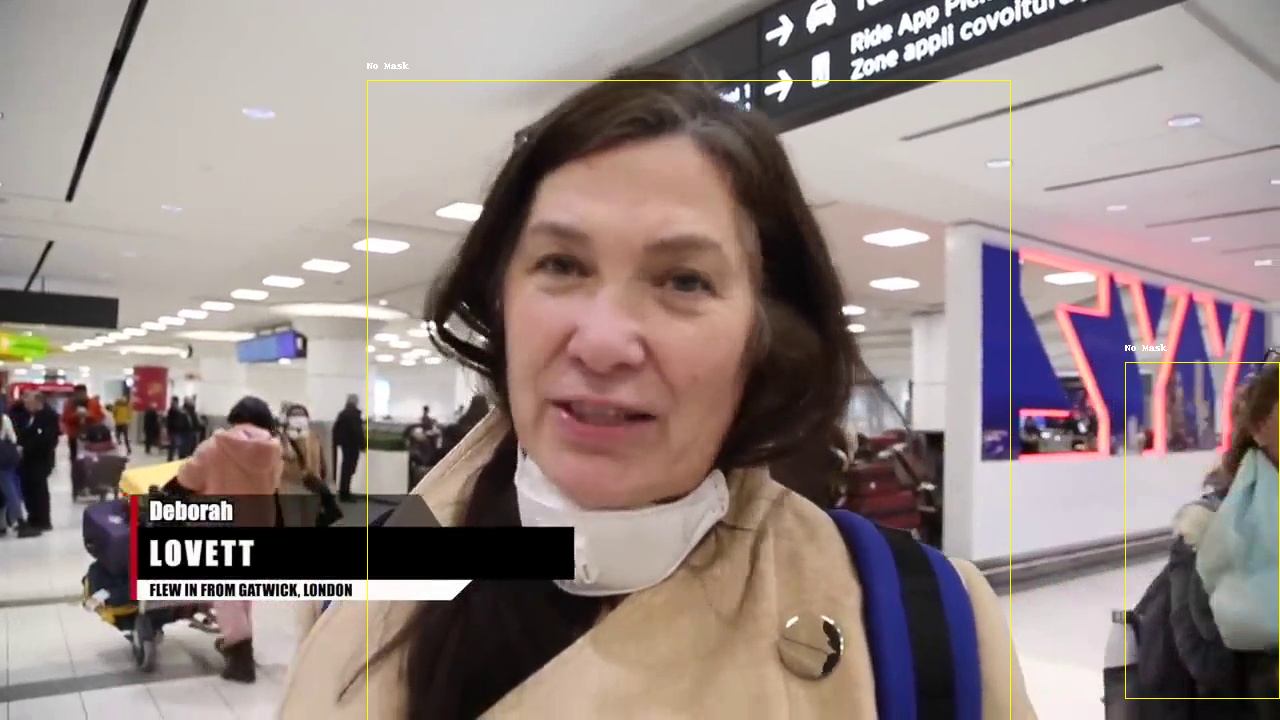

In [42]:
img, targ = dataset_test[1]
preds = get_preds(model,img)
labels,boxes = labels_boxes_above_th(preds,th=0.9)
im = get_img_bbox(img,boxes,labels)
im

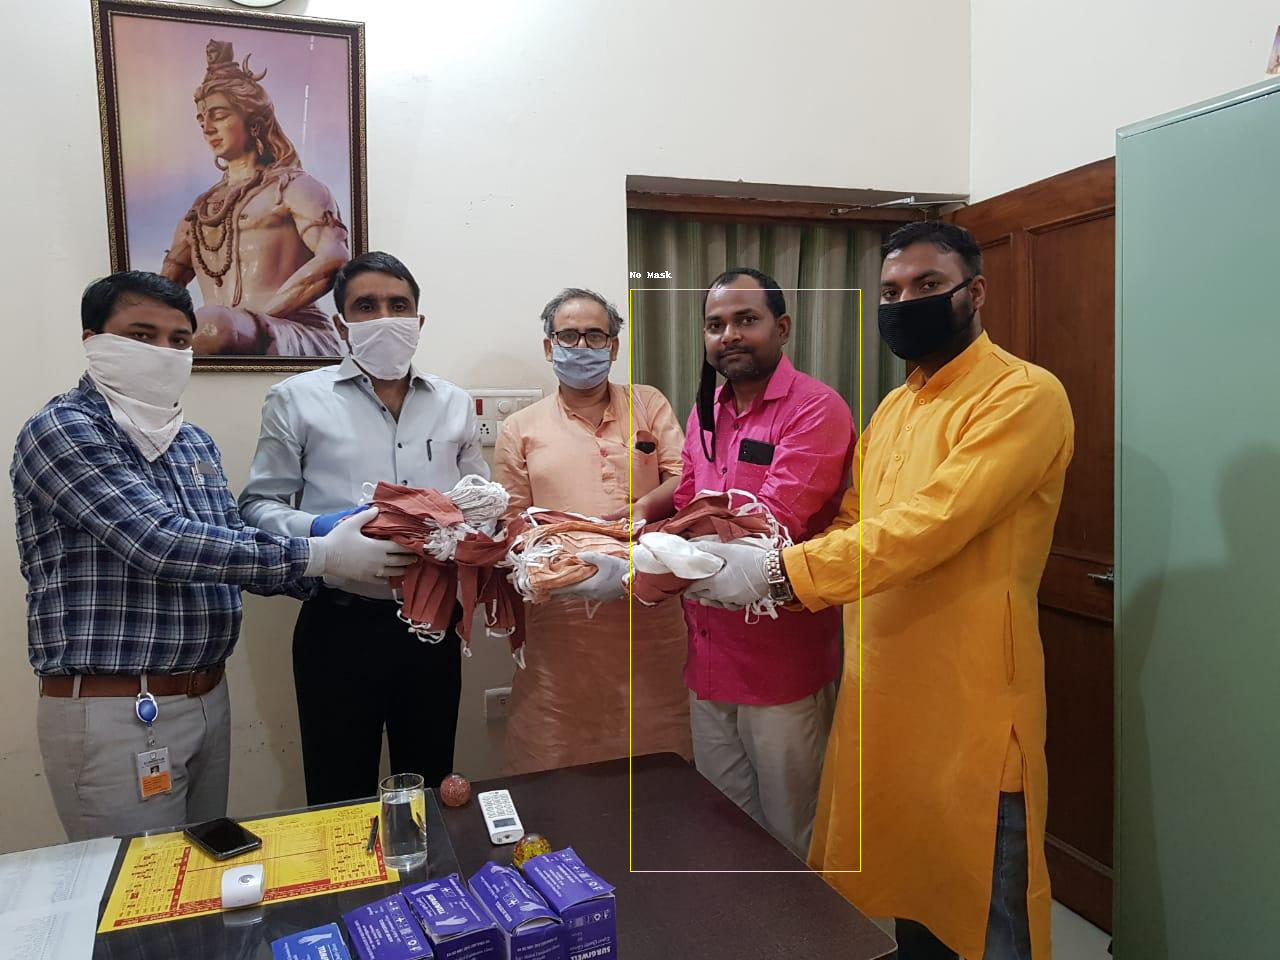

In [41]:
img = get_processed_image('new_masks/0.jpeg')
preds = get_preds(model,img)
labels,boxes = labels_boxes_above_th(preds,th=0.9)
im = get_img_bbox(img,boxes,labels)
im